In [671]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fft import fftn, ifftn
from scipy.fft import fftshift
from scipy.fftpack import fftfreq #(n, d=1.0)¶

import skimage
from scipy.interpolate import interp2d
#from scipy.ndimage import gaussian_filter

# Phase Difference Matrix

Balci, Murat, et Hassan Foroosh. « Subpixel Registration Directly from the Phase Difference ». EURASIP Journal on Advances in Signal Processing 2006, nᵒ 1 (décembre 2006). https://doi.org/10.1155/ASP/2006/60796.


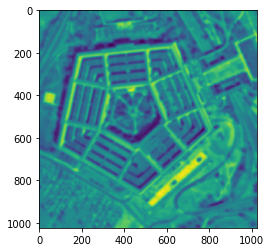

In [672]:
# ================
#  Generate data
# ================

# Pentagon aerial photo
# http://sipi.usc.edu/database/database.php?volume=aerials&image=37#top
image = skimage.data.camera()
image = skimage.io.imread('pentagon_1024.tiff')
image = skimage.exposure.rescale_intensity(image)
image = gaussian_filter(image, sigma=5)
plt.imshow(image);

In [673]:
# Interpolation
#x_span, y_span = np.arange(image.shape[0]), np.arange(image.shape[1])
#x_grid, y_grid = np.meshgrid(x_span, y_span)

#f = interp2d(x_span, y_span, image, kind='cubic')

#x_A = np.arange(20, 281)
#y_A = np.arange(80, 232)a 

#dx, dy = (0.7512, 50.101512)
#A = f(x_A, y_A)
#B = f(x_A + dx, y_A + dy)  #+ 0.81*np.random.randn(*np.shape(A))

#plt.imshow(A - B);

In [674]:
# FFT shift interpolation
def fft_translate(A, dy, dx):
    a = np.fft.fftn(A)
    kx = np.fft.fftfreq(A.shape[0])
    ky = np.fft.fftfreq(A.shape[1])
    k_xy = np.meshgrid(kx, ky, indexing='ij')

    b = a*np.exp(-1j*2*np.pi*(dx*k_xy[0] + dy*k_xy[1]))

    B = np.abs( np.fft.ifftn(b) ) 
    return B

In [675]:
A = np.zeros((5, 8))
A[3, 5] = 1

B = fft_translate(A, -2, -.5)

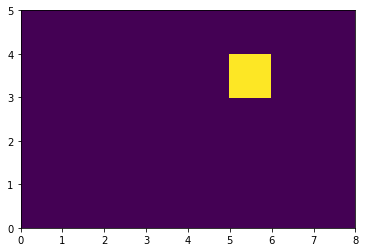

In [676]:
plt.pcolormesh(A)

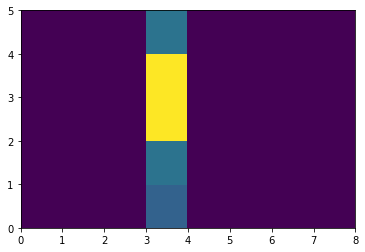

In [677]:
plt.pcolormesh(B)

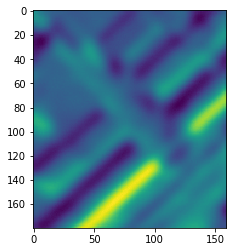

In [707]:
# Translate & Crop

dx, dy = 20.34, 15.23

x, y = 470, 651
Lx, Ly = 160, 180
A = image[y:y+Ly, x:x+Lx]
B = fft_translate(image, dx, dy)[y:y+Ly, x:x+Lx]
B += 0.5*np.random.randn(*B.shape)
plt.imshow(A-B);

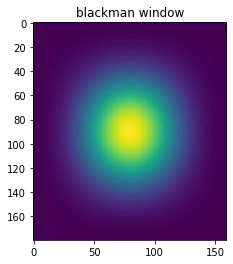

In [712]:
from scipy.signal.windows import blackman

u = blackman(A.shape[0])[:, np.newaxis]
v = blackman(A.shape[1])[np.newaxis, :]
window = np.matmul(u, v)

plt.imshow(window); plt.title('blackman window');

In [716]:
# ====================
#  Fourier Transform
# ====================
#window = 1
a = np.fft.fftn(A*window)
b = np.fft.fftn(B*window)

#a = np.fft.fft2(A)
#b = np.fft.fft2(B)

ab = a * b.conj()
#ab = np.fft.fftshift( ab )

# phase
phi = np.angle(ab)
cos_phi = np.cos(phi).flatten() 
sin_phi = np.sin(phi).flatten() 

# cross-corr
#ab = ab / np.abs(ab)
cross_corr =  np.abs( np.fft.ifft2(ab) )
cross_corr = fftshift(cross_corr)
dy_span = fftshift( fftfreq(cross_corr.shape[0]) )*cross_corr.shape[0]
dx_span = fftshift( fftfreq(cross_corr.shape[1]) )*cross_corr.shape[1]

In [717]:
argmax_idx = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
argmax = -dx_span[argmax_idx[1]], -dy_span[argmax_idx[0]]
print(argmax)

(-0.0, -3.0)


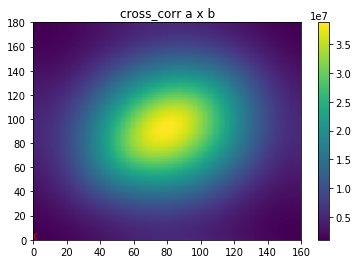

In [741]:
# cross_corr
plt.pcolormesh(cross_corr); #dx_span, dy_span, 
plt.title('cross_corr a x b'); plt.colorbar();
plt.plot(-argmax[0], -argmax[1], 'xr');

In [719]:
from skimage.feature import register_translation as phase_cross_correlation

In [720]:
phase_cross_correlation(A, B, upsample_factor=50)

(array([-13.86, -18.  ]), 0.18580297529310905, -4.064558987049917e-07)

In [721]:
ky = fftshift( fftfreq(phi.shape[0]) )
kx = fftshift( fftfreq(phi.shape[1]) )

Kx, Ky = np.meshgrid(kx, ky)
Kx_flat, Ky_flat = Kx.flatten(), Ky.flatten() 

In [604]:
from scipy.optimize import least_squares
#(fun, x0, jac='2-point', bounds=- inf, inf, method='trf', f

In [605]:
def residuals(p):
    dx, dy = p
    ku = 2*np.pi*(Kx_flat*dx + Ky_flat*dy)
    return np.hstack([np.cos(ku) - cos_phi, np.sin(ku) - sin_phi])

def jac(p):
    dx, dy = p
    ku = 2*np.pi*(Kx_flat*dx + Ky_flat*dy)
    d_dx = np.hstack([-np.sin(ku)*2*np.pi*Kx_flat,
                       np.cos(ku)*2*np.pi*Kx_flat])
    
    d_dy = np.hstack([-np.sin(ku)*2*np.pi*Ky_flat,
                       np.cos(ku)*2*np.pi*Ky_flat])
    return np.vstack([d_dx, d_dy]).T

In [606]:
dx, dy

(2.34, 1.23)

p0 [-0. -0.]
 active_mask: array([0, 0])
        cost: 4439.869348905005
         fun: array([-1.12812558, -1.07846786, -1.02820856, ...,  1.56844887,
        0.9113641 ,  0.9867245 ])
        grad: array([-0.40662975, -1.44291006])
         jac: array([[-3.1156995 , -3.07723407],
       [-3.0200488 , -3.093237  ],
       [-2.91599624, -3.10153447],
       ...,
       [ 0.05965363,  0.06598723],
       [-0.08355804, -0.08887465],
       [-0.2377534 , -0.24351514]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 200
        njev: 199
  optimality: 1.4429100563164496
      status: 0
     success: False
           x: array([0.44488308, 0.09721314])


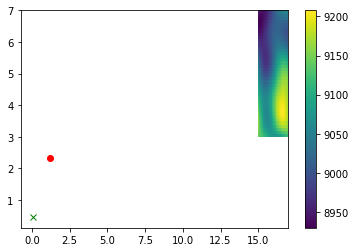

In [607]:
# map the solution space
dx_span = np.linspace(3, 7, 41)
dy_span = np.linspace(15, 17, 38)
dx_grid, dy_grid = np.meshgrid(dx_span, dy_span)
dx_flat, dy_flat = dx_grid.flatten(), dy_grid.flatten()

dxy = np.vstack([dx_flat, dy_flat]).T

r = np.array( [sum(residuals(p)**2) for p in dxy] )

r_grid = r.reshape(dx_grid.shape)

plt.pcolormesh(dy_span, dx_span, r_grid.T);
plt.colorbar();
plt.plot(dy, dx, 'ro')

# opti
p0 = np.array(argmax)
print('p0', p0)
res = least_squares(residuals, p0, method='lm', jac=jac)
plt.plot(res.x[1], res.x[0], 'xg')
print(res)

- actually similar to search max of the inverse transform (DFT)
- Faster than 2nd DFT ? (grid search)
    - according to Manuel Guizar-Sicairos no  
    but why ?  (python ?)
        
- error estimatin -> cov matrix... given by the optim

- cross-correlation (used)  vs phase-correlation
- windowing or not ?

windowing + phase seems to be best...

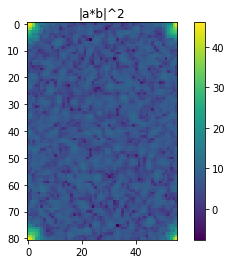

In [608]:
# log FFT^2 
plt.imshow(np.log(np.abs(ab)**2));
plt.title('|a*b|^2'); plt.colorbar();

- fit (cos(phi), sin(phi)) instead of 
the peak summit quadratic, or phi%pi

- but non linear... so do the interpolation&fit directly--> high order transformation

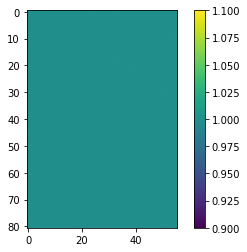

In [609]:
plt.imshow(np.sin(phi)**2 + np.cos(phi)**2 );
plt.colorbar()

In [444]:
from scipy import fft

In [722]:
def custom_dft(data, axis_offsets):
    upsample_factor=1 
    im2pi = 1j * 2 * np.pi

    dim_properties = list(zip(data.shape, axis_offsets))
    for (n_items, ax_offset) in dim_properties[::-1]:
        kernel = ax_offset * fft.fftfreq(n_items, upsample_factor)
        kernel = np.exp(im2pi * kernel)

        # Equivalent to:
        #   data[i, j, k] = kernel[i, :] @ data[j, k].T
        data = np.tensordot(kernel, data, axes=(0, -1))
        
    return data

In [723]:
custom_dft(a, (10, 2))

array(27.22460589+1.65627512e-11j)

In [724]:
a = np.fft.fft2(A)
    

In [725]:
dx_span = np.arange(a.shape[1])
dy_span = np.arange(a.shape[0])
dx_grid, dy_grid = np.meshgrid(dx_span, dy_span)
dx_flat, dy_flat = dx_grid.flatten(), dy_grid.flatten()

In [726]:
A_bis = []
for a_ij in zip(dy_flat, dx_flat):
    A_bis.append( custom_dft(a, a_ij) )

In [727]:
A_bis = np.array(A_bis).reshape(A.shape)

In [728]:
A_bis = np.abs(A_bis)

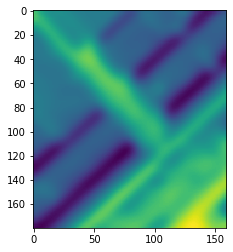

In [729]:
plt.imshow(A_bis)

In [730]:
%%timeit
u = custom_dft(a, (12, 12))

404 µs ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [731]:
%%timeit
phase_cross_correlation(A, B, upsample_factor=50)

14.8 ms ± 684 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [732]:
from _phase_cross_correlation import _upsampled_dft

In [733]:
%%timeit
u = _upsampled_dft(a, 100)

8.24 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [734]:
from scipy.optimize import minimize

In [735]:
dx, dy

(20.34, 15.23)

In [736]:
def cost(p):
    return -np.abs( custom_dft(ab, p) )

In [627]:
cost([3, 2])

-30928415803.044044

In [739]:
minimize(cost, [20, 15], method='CG')

     fun: -1116893590004.5098
     jac: array([    0., 49152.])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 477
     nit: 8
    njev: 115
  status: 2
 success: False
       x: array([ 2.49323872, -0.33132279])

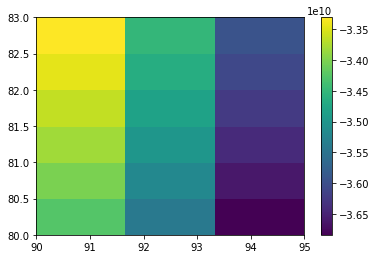

In [740]:
# map the solution space
dx_span = np.linspace(0, 3, 7) + a.shape[1]/2
dy_span = np.linspace(0, 5, 4) + a.shape[0]/2
dx_grid, dy_grid = np.meshgrid(dx_span, dy_span)
dx_flat, dy_flat = dx_grid.flatten(), dy_grid.flatten()

dxy = np.vstack([dx_flat, dy_flat]).T

r = np.array( [cost(p) for p in dxy] )

r_grid = r.reshape(dx_grid.shape)

plt.pcolormesh(dy_span, dx_span, r_grid.T);
plt.colorbar();
#plt.plot(dy, dx, 'ro')